In [1]:
import pandas as pd
import numpy as np
import os
import shutil
import splitfolders
import matplotlib.pyplot as plt
from skimage import transform, io

import tensorflow as tf
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import InceptionV3, ResNet152, InceptionResNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from scikeras.wrappers import KerasClassifier

from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, roc_auc_score,roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import GridSearchCV

import re
import cv2
from PIL import Image

## Load and Split dataset

In [ ]:
df = pd.read_csv(r"C:\Users\n1109899\Downloads\aptos2019-blindness-detection\train.csv", delimiter=",")
df.head()

# Retriving the class list
class_list = df["diagnosis"].unique()
class_list = [int(item) for item in class_list if not np.isnan(item)]
class_list = sorted(class_list)
class_list

## Load and Split dataset

# specify image folder
image_folder = 'train_images'
extension = '.png'

# check for dublicates
df.duplicated().sum()

# get label df columns
df.columns

# order and load all images and labels into arrays
train_ = []
label_ = []
data = []
dims = 299
for image in df["id_code"]:
    image_file = cv2.imread(os.path.join(image_folder,image+extension))
    image_file = cv2.resize(image_file,(dims,dims))
    idx = df["id_code"].tolist().index(image)
    label = df["diagnosis"][idx]
    
    train_.append(image_file)
    label_.append(label)

train_set = np.array(train_)
train_label = np.array(label_)

X_train1,X_test,y_train1,y_test = train_test_split(train_set,train_label,test_size=0.2, shuffle = True, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train1, y_train1, test_size = 0.2, shuffle = True, random_state = True)

X_train.shape,X_test.shape, X_val.shape

y_train.shape,y_test.shape, y_val.shape

# function to scale images
def scale(dataset):
    factor = 255.0
    dataset = dataset/factor
    return dataset

# scale images
X_train= scale(X_train)
X_val = scale(X_val)
X_test = scale(X_test)


## Gradcam Functions

In [234]:
# Function to create gradcam heatmap
# Cholet,F (2022)
# Grad-CAM class activation visualization
# https://keras.io/examples/vision/grad_cam/

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    
    grads = tape.gradient(class_channel, last_conv_layer_output)
    
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [251]:
# Function to save and display gradcam 
# Cholet,F (2022)
# Grad-CAM class activation visualization
# https://keras.io/examples/vision/grad_cam/

def save_and_display_gradcam(img_path, heatmap, alpha, title = '', cam_path="cam.jpg" ):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)
   
    plt.imshow(superimposed_img)
    plt.title(title + " GradCAM")
        
    plt.show()


## Model Development and Training

In [74]:
# function to build model
def build_model_forCAM(pre_trained_network):
    base_model = pre_trained_network(weights = 'imagenet', include_top = False, input_shape = (dims,dims,colour_channel))
    
    for layers in base_model.layers:
        layers.trainable = False

    
    model =GlobalAveragePooling2D()(base_model.output)
    model =Dropout(dropout)(model)
    model =Dense(num_classes, activation = 'softmax')(model)

    model = Model(base_model.input, model)
    print(model.summary())

    #compile model
    #specify optimizer, loss and earlytopping
    adam = tf.keras.optimizers.Adam(learning_rate = lr)
    loss = tf.keras.losses.SparseCategoricalCrossentropy()

    model.compile(optimizer = adam, loss = loss, metrics = METRICS)

    return model

In [22]:
colour_channel =3
epochs = 5
lr = 0.001
METRICS=['accuracy']
batch_size = 32
patience = 10
num_classes = 5
dropout = 0.5
callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = patience)

### Inception V3 CAM

In [76]:
CAM_model = build_model_forCAM(InceptionV3)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d_376 (Conv2D)         (None, 149, 149, 32)         864       ['input_5[0][0]']             
                                                                                                  
 batch_normalization_376 (B  (None, 149, 149, 32)         96        ['conv2d_376[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_376 (Activation  (None, 149, 149, 32)         0         ['batch_normalization_37

                                                                                                  
 conv2d_387 (Conv2D)         (None, 35, 35, 32)           6144      ['average_pooling2d_36[0][0]']
                                                                                                  
 batch_normalization_381 (B  (None, 35, 35, 64)           192       ['conv2d_381[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_383 (B  (None, 35, 35, 64)           192       ['conv2d_383[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_386 (B  (None, 35, 35, 96)           288       ['conv2d_386[0][0]']          
 atchNorma

 )                                                                  ]']                           
                                                                                                  
 activation_393 (Activation  (None, 35, 35, 96)           0         ['batch_normalization_393[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_394 (Activation  (None, 35, 35, 64)           0         ['batch_normalization_394[0][0
 )                                                                  ]']                           
                                                                                                  
 mixed1 (Concatenate)        (None, 35, 35, 288)          0         ['activation_388[0][0]',      
                                                                     'activation_390[0][0]',      
          

 )                                                                  ]']                           
                                                                                                  
 conv2d_404 (Conv2D)         (None, 35, 35, 96)           55296     ['activation_403[0][0]']      
                                                                                                  
 batch_normalization_404 (B  (None, 35, 35, 96)           288       ['conv2d_404[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_404 (Activation  (None, 35, 35, 96)           0         ['batch_normalization_404[0][0
 )                                                                  ]']                           
                                                                                                  
 conv2d_40

                                                                                                  
 conv2d_406 (Conv2D)         (None, 17, 17, 192)          147456    ['mixed3[0][0]']              
                                                                                                  
 conv2d_409 (Conv2D)         (None, 17, 17, 192)          172032    ['activation_408[0][0]']      
                                                                                                  
 conv2d_414 (Conv2D)         (None, 17, 17, 192)          172032    ['activation_413[0][0]']      
                                                                                                  
 conv2d_415 (Conv2D)         (None, 17, 17, 192)          147456    ['average_pooling2d_39[0][0]']
                                                                                                  
 batch_normalization_406 (B  (None, 17, 17, 192)          576       ['conv2d_406[0][0]']          
 atchNorma

 activation_423 (Activation  (None, 17, 17, 160)          0         ['batch_normalization_423[0][0
 )                                                                  ]']                           
                                                                                                  
 average_pooling2d_40 (Aver  (None, 17, 17, 768)          0         ['mixed4[0][0]']              
 agePooling2D)                                                                                    
                                                                                                  
 conv2d_416 (Conv2D)         (None, 17, 17, 192)          147456    ['mixed4[0][0]']              
                                                                                                  
 conv2d_419 (Conv2D)         (None, 17, 17, 192)          215040    ['activation_418[0][0]']      
                                                                                                  
 conv2d_42

 atchNormalization)                                                                               
                                                                                                  
 activation_428 (Activation  (None, 17, 17, 160)          0         ['batch_normalization_428[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_433 (Activation  (None, 17, 17, 160)          0         ['batch_normalization_433[0][0
 )                                                                  ]']                           
                                                                                                  
 average_pooling2d_41 (Aver  (None, 17, 17, 768)          0         ['mixed5[0][0]']              
 agePooling2D)                                                                                    
          

                                                                                                  
 batch_normalization_438 (B  (None, 17, 17, 192)          576       ['conv2d_438[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_443 (B  (None, 17, 17, 192)          576       ['conv2d_443[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_438 (Activation  (None, 17, 17, 192)          0         ['batch_normalization_438[0][0
 )                                                                  ]']                           
                                                                                                  
 activatio

 )                                                                  ]']                           
                                                                                                  
 conv2d_447 (Conv2D)         (None, 8, 8, 320)            552960    ['activation_446[0][0]']      
                                                                                                  
 conv2d_451 (Conv2D)         (None, 8, 8, 192)            331776    ['activation_450[0][0]']      
                                                                                                  
 batch_normalization_447 (B  (None, 8, 8, 320)            960       ['conv2d_447[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_451 (B  (None, 8, 8, 192)            576       ['conv2d_451[0][0]']          
 atchNorma

 )                                                                  ]']                           
                                                                                                  
 activation_458 (Activation  (None, 8, 8, 384)            0         ['batch_normalization_458[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_459 (Activation  (None, 8, 8, 384)            0         ['batch_normalization_459[0][0
 )                                                                  ]']                           
                                                                                                  
 batch_normalization_460 (B  (None, 8, 8, 192)            576       ['conv2d_460[0][0]']          
 atchNormalization)                                                                               
          

 )                                                                  ]']                           
                                                                                                  
 activation_464 (Activation  (None, 8, 8, 384)            0         ['batch_normalization_464[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_467 (Activation  (None, 8, 8, 384)            0         ['batch_normalization_467[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_468 (Activation  (None, 8, 8, 384)            0         ['batch_normalization_468[0][0
 )                                                                  ]']                           
          

In [77]:
CAM_model_history = CAM_model.fit(X_train, y_train, batch_size = batch_size, epochs = 5, validation_data =(X_val, y_val), shuffle =True, callbacks = [callback])
                                            

Epoch 1/5
74/74 [==============================] - 81s 1s/step - loss: 1.0771 - accuracy: 0.6304 - val_loss: 0.8317 - val_accuracy: 0.6997
Epoch 2/5
74/74 [==============================] - 80s 1s/step - loss: 0.8371 - accuracy: 0.7012 - val_loss: 0.7444 - val_accuracy: 0.7338
Epoch 3/5
74/74 [==============================] - 77s 1s/step - loss: 0.7549 - accuracy: 0.7281 - val_loss: 0.6792 - val_accuracy: 0.7577
Epoch 4/5
74/74 [==============================] - 77s 1s/step - loss: 0.6947 - accuracy: 0.7414 - val_loss: 0.6655 - val_accuracy: 0.7662
Epoch 5/5
74/74 [==============================] - 76s 1s/step - loss: 0.6741 - accuracy: 0.7520 - val_loss: 0.6419 - val_accuracy: 0.7543


In [300]:
img_file = r"C:\Users\n1109899\Downloads\aptos2019-blindness-detection\train_images\e4f12411fd85.png"

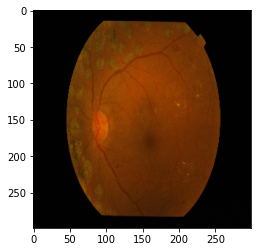

In [301]:
#load image
img = cv2.imread(img_file)
img = cv2.resize(img,(299,299))

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [302]:
img = np.expand_dims(img, axis =0)

In [246]:
last_conv_layer = 'conv2d_469'

In [303]:
heatmap = make_gradcam_heatmap(img, CAM_model, last_conv_layer)

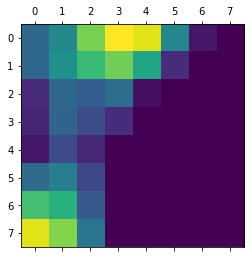

In [304]:
plt.matshow(heatmap)
plt.show()

In [305]:
alpha = 0.4

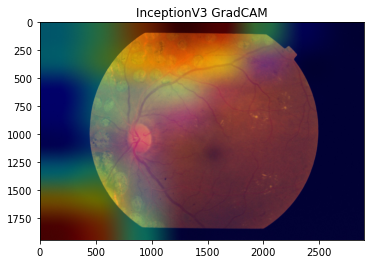

In [306]:
save_and_display_gradcam(img_file, heatmap, alpha, title = 'InceptionV3')

## ResNet152 CAM

In [214]:
Resnet152_CAM_model = build_model_forCAM(ResNet152)

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 305, 305, 3)          0         ['input_7[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 150, 150, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 150, 150, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

                                                                                                  
 conv2_block3_1_conv (Conv2  (None, 75, 75, 64)           16448     ['conv2_block2_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv2_block3_1_bn (BatchNo  (None, 75, 75, 64)           256       ['conv2_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv2_block3_1_relu (Activ  (None, 75, 75, 64)           0         ['conv2_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv2_blo

 ation)                                                                                           
                                                                                                  
 conv3_block2_3_conv (Conv2  (None, 38, 38, 512)          66048     ['conv3_block2_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block2_3_bn (BatchNo  (None, 38, 38, 512)          2048      ['conv3_block2_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block2_add (Add)      (None, 38, 38, 512)          0         ['conv3_block1_out[0][0]',    
                                                                     'conv3_block2_3_bn[0][0]']   
          

 conv3_block5_2_conv (Conv2  (None, 38, 38, 128)          147584    ['conv3_block5_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block5_2_bn (BatchNo  (None, 38, 38, 128)          512       ['conv3_block5_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block5_2_relu (Activ  (None, 38, 38, 128)          0         ['conv3_block5_2_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv3_block5_3_conv (Conv2  (None, 38, 38, 512)          66048     ['conv3_block5_2_relu[0][0]'] 
 D)       

                                                                                                  
 conv3_block8_1_bn (BatchNo  (None, 38, 38, 128)          512       ['conv3_block8_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block8_1_relu (Activ  (None, 38, 38, 128)          0         ['conv3_block8_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv3_block8_2_conv (Conv2  (None, 38, 38, 128)          147584    ['conv3_block8_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_blo

 D)                                                                                               
                                                                                                  
 conv4_block2_3_bn (BatchNo  (None, 19, 19, 1024)         4096      ['conv4_block2_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block2_add (Add)      (None, 19, 19, 1024)         0         ['conv4_block1_out[0][0]',    
                                                                     'conv4_block2_3_bn[0][0]']   
                                                                                                  
 conv4_block2_out (Activati  (None, 19, 19, 1024)         0         ['conv4_block2_add[0][0]']    
 on)                                                                                              
          

 conv4_block5_2_bn (BatchNo  (None, 19, 19, 256)          1024      ['conv4_block5_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block5_2_relu (Activ  (None, 19, 19, 256)          0         ['conv4_block5_2_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block5_3_conv (Conv2  (None, 19, 19, 1024)         263168    ['conv4_block5_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block5_3_bn (BatchNo  (None, 19, 19, 1024)         4096      ['conv4_block5_3_conv[0][0]'] 
 rmalizati

                                                                                                  
 conv4_block8_1_relu (Activ  (None, 19, 19, 256)          0         ['conv4_block8_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block8_2_conv (Conv2  (None, 19, 19, 256)          590080    ['conv4_block8_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block8_2_bn (BatchNo  (None, 19, 19, 256)          1024      ['conv4_block8_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_blo

 ion)                                                                                             
                                                                                                  
 conv4_block11_1_conv (Conv  (None, 19, 19, 256)          262400    ['conv4_block10_out[0][0]']   
 2D)                                                                                              
                                                                                                  
 conv4_block11_1_bn (BatchN  (None, 19, 19, 256)          1024      ['conv4_block11_1_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv4_block11_1_relu (Acti  (None, 19, 19, 256)          0         ['conv4_block11_1_bn[0][0]']  
 vation)                                                                                          
          

 conv4_block13_3_bn (BatchN  (None, 19, 19, 1024)         4096      ['conv4_block13_3_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv4_block13_add (Add)     (None, 19, 19, 1024)         0         ['conv4_block12_out[0][0]',   
                                                                     'conv4_block13_3_bn[0][0]']  
                                                                                                  
 conv4_block13_out (Activat  (None, 19, 19, 1024)         0         ['conv4_block13_add[0][0]']   
 ion)                                                                                             
                                                                                                  
 conv4_block14_1_conv (Conv  (None, 19, 19, 256)          262400    ['conv4_block13_out[0][0]']   
 2D)      

                                                                                                  
 conv4_block16_2_relu (Acti  (None, 19, 19, 256)          0         ['conv4_block16_2_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block16_3_conv (Conv  (None, 19, 19, 1024)         263168    ['conv4_block16_2_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block16_3_bn (BatchN  (None, 19, 19, 1024)         4096      ['conv4_block16_3_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv4_blo

 vation)                                                                                          
                                                                                                  
 conv4_block19_2_conv (Conv  (None, 19, 19, 256)          590080    ['conv4_block19_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block19_2_bn (BatchN  (None, 19, 19, 256)          1024      ['conv4_block19_2_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv4_block19_2_relu (Acti  (None, 19, 19, 256)          0         ['conv4_block19_2_bn[0][0]']  
 vation)                                                                                          
          

 conv4_block22_1_conv (Conv  (None, 19, 19, 256)          262400    ['conv4_block21_out[0][0]']   
 2D)                                                                                              
                                                                                                  
 conv4_block22_1_bn (BatchN  (None, 19, 19, 256)          1024      ['conv4_block22_1_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv4_block22_1_relu (Acti  (None, 19, 19, 256)          0         ['conv4_block22_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block22_2_conv (Conv  (None, 19, 19, 256)          590080    ['conv4_block22_1_relu[0][0]']
 2D)      

                                                                                                  
 conv4_block24_add (Add)     (None, 19, 19, 1024)         0         ['conv4_block23_out[0][0]',   
                                                                     'conv4_block24_3_bn[0][0]']  
                                                                                                  
 conv4_block24_out (Activat  (None, 19, 19, 1024)         0         ['conv4_block24_add[0][0]']   
 ion)                                                                                             
                                                                                                  
 conv4_block25_1_conv (Conv  (None, 19, 19, 256)          262400    ['conv4_block24_out[0][0]']   
 2D)                                                                                              
                                                                                                  
 conv4_blo

 vation)                                                                                          
                                                                                                  
 conv4_block27_3_conv (Conv  (None, 19, 19, 1024)         263168    ['conv4_block27_2_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block27_3_bn (BatchN  (None, 19, 19, 1024)         4096      ['conv4_block27_3_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv4_block27_add (Add)     (None, 19, 19, 1024)         0         ['conv4_block26_out[0][0]',   
                                                                     'conv4_block27_3_bn[0][0]']  
          

 conv4_block30_2_conv (Conv  (None, 19, 19, 256)          590080    ['conv4_block30_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block30_2_bn (BatchN  (None, 19, 19, 256)          1024      ['conv4_block30_2_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv4_block30_2_relu (Acti  (None, 19, 19, 256)          0         ['conv4_block30_2_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block30_3_conv (Conv  (None, 19, 19, 1024)         263168    ['conv4_block30_2_relu[0][0]']
 2D)      

                                                                                                  
 conv4_block33_1_bn (BatchN  (None, 19, 19, 256)          1024      ['conv4_block33_1_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv4_block33_1_relu (Acti  (None, 19, 19, 256)          0         ['conv4_block33_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block33_2_conv (Conv  (None, 19, 19, 256)          590080    ['conv4_block33_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_blo

                                                                     'conv4_block35_3_bn[0][0]']  
                                                                                                  
 conv4_block35_out (Activat  (None, 19, 19, 1024)         0         ['conv4_block35_add[0][0]']   
 ion)                                                                                             
                                                                                                  
 conv4_block36_1_conv (Conv  (None, 19, 19, 256)          262400    ['conv4_block35_out[0][0]']   
 2D)                                                                                              
                                                                                                  
 conv4_block36_1_bn (BatchN  (None, 19, 19, 256)          1024      ['conv4_block36_1_conv[0][0]']
 ormalization)                                                                                    
          

 conv5_block2_2_bn (BatchNo  (None, 10, 10, 512)          2048      ['conv5_block2_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block2_2_relu (Activ  (None, 10, 10, 512)          0         ['conv5_block2_2_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block2_3_conv (Conv2  (None, 10, 10, 2048)         1050624   ['conv5_block2_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_block2_3_bn (BatchNo  (None, 10, 10, 2048)         8192      ['conv5_block2_3_conv[0][0]'] 
 rmalizati

In [215]:
Resnet152_CAM_model_history = Resnet152_CAM_model.fit(X_train, y_train, batch_size = batch_size, epochs = 5, validation_data =(X_val, y_val), shuffle =True, callbacks = [callback])
                                            

Epoch 1/5
74/74 [==============================] - 408s 5s/step - loss: 1.5163 - accuracy: 0.4289 - val_loss: 1.2604 - val_accuracy: 0.4693
Epoch 2/5
74/74 [==============================] - 447s 6s/step - loss: 1.3772 - accuracy: 0.4840 - val_loss: 1.2227 - val_accuracy: 0.4710
Epoch 3/5
74/74 [==============================] - 451s 6s/step - loss: 1.3288 - accuracy: 0.5109 - val_loss: 1.1852 - val_accuracy: 0.6570
Epoch 4/5
74/74 [==============================] - 441s 6s/step - loss: 1.2748 - accuracy: 0.5305 - val_loss: 1.1502 - val_accuracy: 0.5171
Epoch 5/5
74/74 [==============================] - 448s 6s/step - loss: 1.2171 - accuracy: 0.5493 - val_loss: 1.1295 - val_accuracy: 0.6519


In [253]:
Resnet_last_conv_layer = 'conv5_block3_3_conv'

In [307]:
Resnet_heatmap = make_gradcam_heatmap(img, Resnet152_CAM_model, Resnet_last_conv_layer)

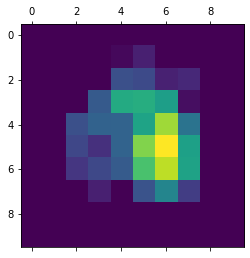

In [308]:
plt.matshow(Resnet_heatmap)
plt.show()

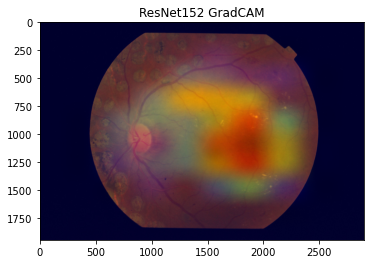

In [309]:
save_and_display_gradcam(img_file, Resnet_heatmap, alpha, title = 'ResNet152')

## InceptionResNet V2 CAM

In [207]:
InceptionResnet_CAM_model = build_model_forCAM(InceptionResNetV2)

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d_470 (Conv2D)         (None, 149, 149, 32)         864       ['input_6[0][0]']             
                                                                                                  
 batch_normalization_470 (B  (None, 149, 149, 32)         96        ['conv2d_470[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_470 (Activation  (None, 149, 149, 32)         0         ['batch_normalization_47

                                                                                                  
 conv2d_481 (Conv2D)         (None, 35, 35, 64)           12288     ['average_pooling2d_45[0][0]']
                                                                                                  
 batch_normalization_475 (B  (None, 35, 35, 96)           288       ['conv2d_475[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_477 (B  (None, 35, 35, 64)           192       ['conv2d_477[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_480 (B  (None, 35, 35, 96)           288       ['conv2d_480[0][0]']          
 atchNorma

                                                                                                  
 block35_1_conv (Conv2D)     (None, 35, 35, 320)          41280     ['block35_1_mixed[0][0]']     
                                                                                                  
 custom_scale_layer (Custom  (None, 35, 35, 320)          0         ['mixed_5b[0][0]',            
 ScaleLayer)                                                         'block35_1_conv[0][0]']      
                                                                                                  
 block35_1_ac (Activation)   (None, 35, 35, 320)          0         ['custom_scale_layer[0][0]']  
                                                                                                  
 conv2d_491 (Conv2D)         (None, 35, 35, 32)           10240     ['block35_1_ac[0][0]']        
                                                                                                  
 batch_nor

 atchNormalization)                                                                               
                                                                                                  
 activation_495 (Activation  (None, 35, 35, 32)           0         ['batch_normalization_495[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_498 (Activation  (None, 35, 35, 48)           0         ['batch_normalization_498[0][0
 )                                                                  ]']                           
                                                                                                  
 conv2d_494 (Conv2D)         (None, 35, 35, 32)           10240     ['block35_2_ac[0][0]']        
                                                                                                  
 conv2d_49

 )                                                                  ]']                           
                                                                                                  
 activation_502 (Activation  (None, 35, 35, 32)           0         ['batch_normalization_502[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_505 (Activation  (None, 35, 35, 64)           0         ['batch_normalization_505[0][0
 )                                                                  ]']                           
                                                                                                  
 block35_4_mixed (Concatena  (None, 35, 35, 128)          0         ['activation_500[0][0]',      
 te)                                                                 'activation_502[0][0]',      
          

 activation_515 (Activation  (None, 35, 35, 32)           0         ['batch_normalization_515[0][0
 )                                                                  ]']                           
                                                                                                  
 conv2d_513 (Conv2D)         (None, 35, 35, 32)           10240     ['block35_5_ac[0][0]']        
                                                                                                  
 conv2d_516 (Conv2D)         (None, 35, 35, 48)           13824     ['activation_515[0][0]']      
                                                                                                  
 batch_normalization_513 (B  (None, 35, 35, 32)           96        ['conv2d_513[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_nor

                                                                                                  
 batch_normalization_518 (B  (None, 35, 35, 32)           96        ['conv2d_518[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_520 (B  (None, 35, 35, 32)           96        ['conv2d_520[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_523 (B  (None, 35, 35, 64)           192       ['conv2d_523[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activatio

                                                                                                  
 custom_scale_layer_7 (Cust  (None, 35, 35, 320)          0         ['block35_7_ac[0][0]',        
 omScaleLayer)                                                       'block35_8_conv[0][0]']      
                                                                                                  
 block35_8_ac (Activation)   (None, 35, 35, 320)          0         ['custom_scale_layer_7[0][0]']
                                                                                                  
 conv2d_533 (Conv2D)         (None, 35, 35, 32)           10240     ['block35_8_ac[0][0]']        
                                                                                                  
 batch_normalization_533 (B  (None, 35, 35, 32)           96        ['conv2d_533[0][0]']          
 atchNormalization)                                                                               
          

 activation_537 (Activation  (None, 35, 35, 32)           0         ['batch_normalization_537[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_540 (Activation  (None, 35, 35, 48)           0         ['batch_normalization_540[0][0
 )                                                                  ]']                           
                                                                                                  
 conv2d_536 (Conv2D)         (None, 35, 35, 32)           10240     ['block35_9_ac[0][0]']        
                                                                                                  
 conv2d_538 (Conv2D)         (None, 35, 35, 32)           9216      ['activation_537[0][0]']      
                                                                                                  
 conv2d_54

 atchNormalization)                                                                               
                                                                                                  
 activation_547 (Activation  (None, 17, 17, 128)          0         ['batch_normalization_547[0][0
 )                                                                  ]']                           
                                                                                                  
 conv2d_548 (Conv2D)         (None, 17, 17, 160)          143360    ['activation_547[0][0]']      
                                                                                                  
 batch_normalization_548 (B  (None, 17, 17, 160)          480       ['conv2d_548[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activatio

 conv2d_555 (Conv2D)         (None, 17, 17, 128)          139264    ['block17_2_ac[0][0]']        
                                                                                                  
 batch_normalization_555 (B  (None, 17, 17, 128)          384       ['conv2d_555[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_555 (Activation  (None, 17, 17, 128)          0         ['batch_normalization_555[0][0
 )                                                                  ]']                           
                                                                                                  
 conv2d_556 (Conv2D)         (None, 17, 17, 160)          143360    ['activation_555[0][0]']      
                                                                                                  
 batch_nor

 block17_4_ac (Activation)   (None, 17, 17, 1088)         0         ['custom_scale_layer_13[0][0]'
                                                                    ]                             
                                                                                                  
 conv2d_563 (Conv2D)         (None, 17, 17, 128)          139264    ['block17_4_ac[0][0]']        
                                                                                                  
 batch_normalization_563 (B  (None, 17, 17, 128)          384       ['conv2d_563[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_563 (Activation  (None, 17, 17, 128)          0         ['batch_normalization_563[0][0
 )                                                                  ]']                           
          

 custom_scale_layer_15 (Cus  (None, 17, 17, 1088)         0         ['block17_5_ac[0][0]',        
 tomScaleLayer)                                                      'block17_6_conv[0][0]']      
                                                                                                  
 block17_6_ac (Activation)   (None, 17, 17, 1088)         0         ['custom_scale_layer_15[0][0]'
                                                                    ]                             
                                                                                                  
 conv2d_571 (Conv2D)         (None, 17, 17, 128)          139264    ['block17_6_ac[0][0]']        
                                                                                                  
 batch_normalization_571 (B  (None, 17, 17, 128)          384       ['conv2d_571[0][0]']          
 atchNormalization)                                                                               
          

                                                                                                  
 block17_8_conv (Conv2D)     (None, 17, 17, 1088)         418880    ['block17_8_mixed[0][0]']     
                                                                                                  
 custom_scale_layer_17 (Cus  (None, 17, 17, 1088)         0         ['block17_7_ac[0][0]',        
 tomScaleLayer)                                                      'block17_8_conv[0][0]']      
                                                                                                  
 block17_8_ac (Activation)   (None, 17, 17, 1088)         0         ['custom_scale_layer_17[0][0]'
                                                                    ]                             
                                                                                                  
 conv2d_579 (Conv2D)         (None, 17, 17, 128)          139264    ['block17_8_ac[0][0]']        
          

                                                                                                  
 block17_10_mixed (Concaten  (None, 17, 17, 384)          0         ['activation_582[0][0]',      
 ate)                                                                'activation_585[0][0]']      
                                                                                                  
 block17_10_conv (Conv2D)    (None, 17, 17, 1088)         418880    ['block17_10_mixed[0][0]']    
                                                                                                  
 custom_scale_layer_19 (Cus  (None, 17, 17, 1088)         0         ['block17_9_ac[0][0]',        
 tomScaleLayer)                                                      'block17_10_conv[0][0]']     
                                                                                                  
 block17_10_ac (Activation)  (None, 17, 17, 1088)         0         ['custom_scale_layer_19[0][0]'
          

                                                                                                  
 activation_593 (Activation  (None, 17, 17, 192)          0         ['batch_normalization_593[0][0
 )                                                                  ]']                           
                                                                                                  
 block17_12_mixed (Concaten  (None, 17, 17, 384)          0         ['activation_590[0][0]',      
 ate)                                                                'activation_593[0][0]']      
                                                                                                  
 block17_12_conv (Conv2D)    (None, 17, 17, 1088)         418880    ['block17_12_mixed[0][0]']    
                                                                                                  
 custom_scale_layer_21 (Cus  (None, 17, 17, 1088)         0         ['block17_11_ac[0][0]',       
 tomScaleL

                                                                                                  
 activation_598 (Activation  (None, 17, 17, 192)          0         ['batch_normalization_598[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_601 (Activation  (None, 17, 17, 192)          0         ['batch_normalization_601[0][0
 )                                                                  ]']                           
                                                                                                  
 block17_14_mixed (Concaten  (None, 17, 17, 384)          0         ['activation_598[0][0]',      
 ate)                                                                'activation_601[0][0]']      
                                                                                                  
 block17_1

                                                                                                  
 batch_normalization_609 (B  (None, 17, 17, 192)          576       ['conv2d_609[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_606 (Activation  (None, 17, 17, 192)          0         ['batch_normalization_606[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_609 (Activation  (None, 17, 17, 192)          0         ['batch_normalization_609[0][0
 )                                                                  ]']                           
                                                                                                  
 block17_1

                                                                                                  
 batch_normalization_614 (B  (None, 17, 17, 192)          576       ['conv2d_614[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_617 (B  (None, 17, 17, 192)          576       ['conv2d_617[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_614 (Activation  (None, 17, 17, 192)          0         ['batch_normalization_614[0][0
 )                                                                  ]']                           
                                                                                                  
 activatio

 conv2d_622 (Conv2D)         (None, 17, 17, 192)          208896    ['block17_19_ac[0][0]']       
                                                                                                  
 conv2d_625 (Conv2D)         (None, 17, 17, 192)          215040    ['activation_624[0][0]']      
                                                                                                  
 batch_normalization_622 (B  (None, 17, 17, 192)          576       ['conv2d_622[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_625 (B  (None, 17, 17, 192)          576       ['conv2d_625[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activatio

 max_pooling2d_23 (MaxPooli  (None, 8, 8, 1088)           0         ['block17_20_ac[0][0]']       
 ng2D)                                                                                            
                                                                                                  
 mixed_7a (Concatenate)      (None, 8, 8, 2080)           0         ['activation_627[0][0]',      
                                                                     'activation_629[0][0]',      
                                                                     'activation_632[0][0]',      
                                                                     'max_pooling2d_23[0][0]']    
                                                                                                  
 conv2d_634 (Conv2D)         (None, 8, 8, 192)            399360    ['mixed_7a[0][0]']            
                                                                                                  
 batch_nor

 block8_2_mixed (Concatenat  (None, 8, 8, 448)            0         ['activation_637[0][0]',      
 e)                                                                  'activation_640[0][0]']      
                                                                                                  
 block8_2_conv (Conv2D)      (None, 8, 8, 2080)           933920    ['block8_2_mixed[0][0]']      
                                                                                                  
 custom_scale_layer_31 (Cus  (None, 8, 8, 2080)           0         ['block8_1_ac[0][0]',         
 tomScaleLayer)                                                      'block8_2_conv[0][0]']       
                                                                                                  
 block8_2_ac (Activation)    (None, 8, 8, 2080)           0         ['custom_scale_layer_31[0][0]'
                                                                    ]                             
          

 activation_648 (Activation  (None, 8, 8, 256)            0         ['batch_normalization_648[0][0
 )                                                                  ]']                           
                                                                                                  
 block8_4_mixed (Concatenat  (None, 8, 8, 448)            0         ['activation_645[0][0]',      
 e)                                                                  'activation_648[0][0]']      
                                                                                                  
 block8_4_conv (Conv2D)      (None, 8, 8, 2080)           933920    ['block8_4_mixed[0][0]']      
                                                                                                  
 custom_scale_layer_33 (Cus  (None, 8, 8, 2080)           0         ['block8_3_ac[0][0]',         
 tomScaleLayer)                                                      'block8_4_conv[0][0]']       
          

 activation_653 (Activation  (None, 8, 8, 192)            0         ['batch_normalization_653[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_656 (Activation  (None, 8, 8, 256)            0         ['batch_normalization_656[0][0
 )                                                                  ]']                           
                                                                                                  
 block8_6_mixed (Concatenat  (None, 8, 8, 448)            0         ['activation_653[0][0]',      
 e)                                                                  'activation_656[0][0]']      
                                                                                                  
 block8_6_conv (Conv2D)      (None, 8, 8, 2080)           933920    ['block8_6_mixed[0][0]']      
          

 batch_normalization_664 (B  (None, 8, 8, 256)            768       ['conv2d_664[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_661 (Activation  (None, 8, 8, 192)            0         ['batch_normalization_661[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_664 (Activation  (None, 8, 8, 256)            0         ['batch_normalization_664[0][0
 )                                                                  ]']                           
                                                                                                  
 block8_8_mixed (Concatenat  (None, 8, 8, 448)            0         ['activation_661[0][0]',      
 e)       

 batch_normalization_669 (B  (None, 8, 8, 192)            576       ['conv2d_669[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_672 (B  (None, 8, 8, 256)            768       ['conv2d_672[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_669 (Activation  (None, 8, 8, 192)            0         ['batch_normalization_669[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_672 (Activation  (None, 8, 8, 256)            0         ['batch_normalization_672[0][0
 )        

In [208]:
InceptionResnet_CAM_model_history = InceptionResnet_CAM_model.fit(X_train, y_train, batch_size = batch_size, epochs = 5, validation_data =(X_val, y_val), shuffle =True, callbacks = [callback])
                                            

Epoch 1/5
74/74 [==============================] - 230s 3s/step - loss: 1.1862 - accuracy: 0.5770 - val_loss: 0.8620 - val_accuracy: 0.7082
Epoch 2/5
74/74 [==============================] - 231s 3s/step - loss: 0.9307 - accuracy: 0.6620 - val_loss: 0.7666 - val_accuracy: 0.7184
Epoch 3/5
74/74 [==============================] - 222s 3s/step - loss: 0.8265 - accuracy: 0.6918 - val_loss: 0.7668 - val_accuracy: 0.7099
Epoch 4/5
74/74 [==============================] - 216s 3s/step - loss: 0.8019 - accuracy: 0.6970 - val_loss: 0.7086 - val_accuracy: 0.7253
Epoch 5/5
74/74 [==============================] - 219s 3s/step - loss: 0.7602 - accuracy: 0.7226 - val_loss: 0.7142 - val_accuracy: 0.7372


In [312]:
InceptionResnet_last_conv_layer = 'conv_7b'

In [313]:
inceptionResnet_heatmap = make_gradcam_heatmap(img, InceptionResnet_CAM_model, InceptionResnet_last_conv_layer)

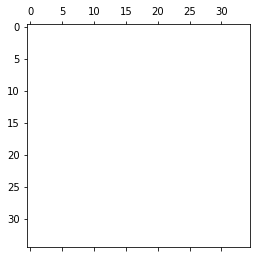

In [314]:
plt.matshow(inceptionResnet_heatmap)
plt.show()

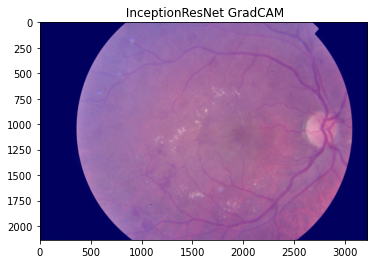

In [299]:
save_and_display_gradcam(img_file, inceptionResnet_heatmap, alpha, title = ' InceptionResNet')